# PASCAL VOC 2007

In [1]:
from pathlib import Path
from natsort import natsorted

# image_dir = Path('./dataset/PASCALVOC2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/')
# label_dir = Path('./dataset/PASCALVOC2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/')

image_dir = Path('./dataset/PASCALVOC2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/')
label_dir = Path('./dataset/PASCALVOC2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations/')

image_pattern = '*.jpg'
label_pattern = '*.xml'

image_paths = natsorted(image_dir.glob(image_pattern), key=lambda x: x.stem)
label_paths = natsorted(label_dir.glob(label_pattern), key=lambda x: x.stem)

data_pairs = [(image_path, label_path) for image_path, label_path in zip(image_paths, label_paths) if image_path.stem == label_path.stem]

print(len(data_pairs))

4952


# Dataset

In [2]:
from pathlib import Path
from natsort import natsorted

datadir = Path('./dataset/VOC2007/')
image_pattern = '*.jpg'
label_pattern = '*.xml'

statistics = {}

for set_name in ['train', 'test', 'valid']:
    image_paths = natsorted(datadir.joinpath(set_name).glob(image_pattern), key=lambda x: x.stem)
    label_paths = natsorted(datadir.joinpath(set_name).glob(label_pattern), key=lambda x: x.stem)
    data_pairs = [(image_path, label_path) for image_path, label_path in zip(image_paths, label_paths) if image_path.stem == label_path.stem]
    statistics[set_name] = len(data_pairs)
statistics

{'train': 6376, 'test': 1993, 'valid': 1594}

In [3]:
from flame.core.data.voc2007_dataset import VOC2007Dataset

import cv2
import torch
import numpy as np
import imgaug.augmenters as iaa
from torch.utils.data import DataLoader

classes2idx = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
               'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10,
               'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
               'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

transforms = [iaa.Add(value=(-10, 10), per_channel=True),
              iaa.GaussianBlur(sigma=(0, 1)),
              iaa.MotionBlur(),
              iaa.JpegCompression(compression=(0, 10)),
              iaa.Fliplr(p=0.5),
              iaa.Flipud(p=0.5),
              iaa.Grayscale(alpha=(0.0, 0.1)),
#               iaa.Rot90(k=[0, 1, 2, 3], keep_size=False),
              iaa.Affine(rotate=(-5, 5), shear=(-5, 5), fit_output=True),
              iaa.Crop(percent=(0, 0.1)),
              iaa.Pad(percent=(0, 0.1), keep_size=False),
              iaa.ChangeColorTemperature()]

image_dir = './dataset/PASCALVOC2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
label_dir = './dataset/PASCALVOC2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations/'

voc2007_dataset = VOC2007Dataset(image_dir=image_dir, label_dir=label_dir,
                                 image_pattern='*.jpg', label_pattern='*.xml',
                                 mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], compound_coef=0,
                                 classes=classes2idx, transforms=transforms)

print(f'number of dataset: {len(voc2007_dataset)}')

JPEGImages: 4952
number of dataset: 4952


In [4]:
voc_loader = DataLoader(voc2007_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float).view(3, 1, 1)
idx2class = {idx: label_name for label_name, idx in classes2idx.items()}

for i, voc_data in enumerate(iter(voc_loader)):
    samples, targets, sample_infos = voc_data
    for sample, target in zip(samples, targets):
        image = ((sample * std + mean) * 255).permute(1, 2, 0).to(torch.uint8).cpu().numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        boxes = target['boxes'].data.cpu().numpy().astype(np.int32)
        labels = target['labels'].data.cpu().numpy().astype(np.int32)
        for box, label in zip(boxes, labels):
            if label != -1:
                image = np.ascontiguousarray(image)
                cv2.rectangle(img=image, pt1=(int(box[0]), int(box[1])), pt2=(int(box[2]), int(box[3])),
                              color=(0, 255, 0), thickness=1)
                cv2.putText(img=image, text=idx2class[int(label)], org=tuple(box[:2]),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.001 * max(image.shape[0], image.shape[1]),
                            color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
        cv2.imshow('image', image)
        cv2.waitKey()
        cv2.destroyAllWindows()
    if i == 1:
        break

# Dataset TABLE

In [16]:
from pathlib import Path
from natsort import natsorted

datadir = Path('./dataset/TABLE/')
image_pattern = '**/*.jpg'
label_pattern = '**/*.json'

statistics = {}

for set_name in ['train', 'test', 'valid']:
    image_paths = natsorted(datadir.joinpath(set_name).glob(image_pattern), key=lambda x: x.stem)
    label_paths = natsorted(datadir.joinpath(set_name).glob(label_pattern), key=lambda x: x.stem)
    data_pairs = [(image_path, label_path) for image_path, label_path in zip(image_paths, label_paths) if image_path.stem == label_path.stem]
    statistics[set_name] = len(data_pairs)

statistics

{'train': 216, 'test': 65, 'valid': 54}

In [20]:
from flame.core.data.table_dataset import TableDataset

import cv2
import torch
import numpy as np
import imgaug.augmenters as iaa
from torch.utils.data import DataLoader

classes = {'TABLE': 0, 'borderless_table': 0, 'bordered_table': 0, 'color_table': 0}

transforms = [iaa.Add(value=(-10, 10), per_channel=True),
              iaa.GaussianBlur(sigma=(0, 1)),
              iaa.MotionBlur(),
              iaa.JpegCompression(compression=(0, 10)),
              iaa.Fliplr(p=0.5),
              iaa.Flipud(p=0.5),
              iaa.Grayscale(alpha=(0.0, 0.1)),
#               iaa.Rot90(k=[0, 1, 2, 3], keep_size=False),
              iaa.Affine(rotate=(-5, 5), shear=(-5, 5), fit_output=True),
              iaa.Crop(percent=(0, 0.1)),
              iaa.Pad(percent=(0, 0.1), keep_size=False),
              iaa.ChangeColorTemperature()]


table_dataset = TableDataset(dirname='./dataset/TABLE/train/', image_patterns=['*.jpg'], label_patterns=['*.json'],
                             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], compound_coef=0,
                             classes=classes, transforms=transforms)

print(f'number of dataset: {len(table_dataset)}')

train: 216
number of dataset: 216


In [23]:
voc_loader = DataLoader(table_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float).view(3, 1, 1)
idx2class = {idx: label_name for label_name, idx in classes.items()}

for i, voc_data in enumerate(iter(voc_loader)):
    samples, targets, sample_infos = voc_data
    for sample, target in zip(samples, targets):
        image = ((sample * std + mean) * 255).permute(1, 2, 0).to(torch.uint8).cpu().numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        boxes = target['boxes'].data.cpu().numpy().astype(np.int32)
        labels = target['labels'].data.cpu().numpy().astype(np.int32)
        for box, label in zip(boxes, labels):
            if label != -1:
                image = np.ascontiguousarray(image)
                cv2.rectangle(img=image, pt1=(int(box[0]), int(box[1])), pt2=(int(box[2]), int(box[3])),
                              color=(0, 255, 0), thickness=1)
                cv2.putText(img=image, text=idx2class[int(label)], org=tuple(box[:2]),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.001 * max(image.shape[0], image.shape[1]),
                            color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
        cv2.imshow('image', image)
        cv2.waitKey()
        cv2.destroyAllWindows()
    if i == 1:
        break

# Model

In [6]:
import torch
from flame.core.model.efficientdet import EfficientDet

pretrained_weight = './checkpoint/efficientdet_pretrained_weight/efficientdet-d1.pth'
head_only = False
num_classes = 20
compound_coef = 1
backbone_pretrained = False
scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]
aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
iou_threshold = 0.2
score_threshold = 0.2

model = EfficientDet(pretrained_weight=pretrained_weight,
                     head_only=head_only,
                     num_classes=num_classes,
                     compound_coef=compound_coef,
                     backbone_pretrained=backbone_pretrained,
                     scales=scales, aspect_ratios=aspect_ratios,
                     iou_threshold=iou_threshold,
                     score_threshold=score_threshold)
model = model.train()

In [7]:
total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(total_params)

6569828


In [3]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-----------------------------------------------------------------+------------+
|                             Modules                             | Parameters |
+-----------------------------------------------------------------+------------+
|                       model.bifpn.0.p6_w1                       |     2      |
|                       model.bifpn.0.p5_w1                       |     2      |
|                       model.bifpn.0.p4_w1                       |     2      |
|                       model.bifpn.0.p3_w1                       |     2      |
|                       model.bifpn.0.p4_w2                       |     3      |
|                       model.bifpn.0.p5_w2                       |     3      |
|                       model.bifpn.0.p6_w2                       |     3      |
|                       model.bifpn.0.p7_w2                       |     2      |
|        model.bifpn.0.conv6_up.depthwise_conv.conv.weight        |    576     |
|        model.bifpn.0.conv6

3839117

In [22]:
voc_iter = iter(voc_loader)
samples, targets, image_infos = voc_iter.next()

In [23]:
cls_preds, reg_preds, anchors = model(samples)
print(cls_preds.shape)
print(reg_preds.shape)
print(anchors.shape)

torch.Size([2, 49104, 20])
torch.Size([2, 49104, 4])
torch.Size([1, 49104, 4])


# Loss

In [24]:
from flame.core.loss.focal_loss import FocalLoss

loss = FocalLoss(alpha=0.25, gamma=2.0, lamda=50.0, device='cpu')

In [25]:
loss(cls_preds, reg_preds, anchors, targets)

(tensor([10546.2178], grad_fn=<MeanBackward1>),
 tensor([3.1572], grad_fn=<MulBackward0>))

# Inference

In [11]:
from flame.core.model.efficientdet import EfficientDet

compound_coef = 0

model = EfficientDet(pretrained_weight=None,
                     head_only=False,
                     num_classes=90,
                     compound_coef=compound_coef,
                     backbone_pretrained=False,
                     score_threshold=0.3)
model.load_state_dict(torch.load(f'./checkpoint/efficientdet_pretrained_weight/efficientdet-d{compound_coef}.pth', map_location='cpu'))
# model.requires_grad_(False)
model = model.eval()

In [12]:
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']

In [13]:
import cv2
import torch
import numpy as np
import imgaug.augmenters as iaa

pad_to_square = iaa.PadToSquare(position='right-bottom')
device = 'cpu'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float).view(1, 3, 1, 1)

imsize = 512 + 128 * compound_coef

def preprocess(image_paths, imsize=imsize, mean=mean, std=std, device=device):
    images = [cv2.imread(image_path) for image_path in image_paths]
    padded_images = [pad_to_square(image=image) for image in images]
    samples = [cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB) for padded_image in padded_images]
    samples = [cv2.resize(sample, dsize=(imsize, imsize)) for sample in samples]
    samples = [torch.from_numpy(sample) for sample in samples]
    samples = torch.stack(samples, dim=0).to(device)
    samples = samples.permute(0, 3, 1, 2).contiguous()
    samples = (samples.float().div(255.) - mean) / std
    scales = [max(*image.shape) / imsize for image in images]
    return images, scales, samples

In [20]:
# image_paths = ['./dataset/VOC2007/valid/000002.jpg',
#                './dataset/VOC2007/valid/000013.jpg',
#                './dataset/VOC2007/valid/000030.jpg']
image_paths = ['./dataset/VOC2007/valid/000002.jpg']
images, scales, samples = preprocess(image_paths=image_paths)

In [21]:
import time
t1 = time.time()
with torch.no_grad():
    predictions = model(samples)
t2 = time.time()
print(f'prediction time: {t2 - t1}s')

prediction time: 0.3552844524383545s


In [22]:
predictions

[{'boxes': tensor([[143.4082, 203.5088, 211.8467, 306.7638]]),
  'labels': tensor([6]),
  'scores': tensor([0.7441])}]

In [23]:
for image, scale, pred in zip(images, scales, predictions):
    boxes = pred['boxes'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    class_names = [classes[label] for label in labels]
    boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale
    boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale
    boxes = boxes.astype(np.int32)
    for box, score, class_name in zip(boxes, scores, class_names):
        color = (np.random.randint(200, 255),
                 np.random.randint(50, 200),
                 np.random.randint(0, 150))
        cv2.putText(image,
                    text=f'{class_name}',
                    org=tuple(box[:2]),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.001 * max(image.shape[0], image.shape[1]),
                    color=color,
                    thickness=1,
                    lineType=cv2.LINE_AA)
        cv2.rectangle(image, pt1=tuple(box[:2]), pt2=tuple(box[2:]), color=color, thickness=3)
        cv2.imshow('a', image)
        cv2.waitKey()
        cv2.destroyAllWindows()

In [1]:
import torch
from torch import nn


class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    '''

    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [24]:
x = torch.arange(start=-10, end=10, step=0.01)

In [25]:
y_silu = SiLU()(x).numpy()
y_relu = nn.ReLU6()(x).numpy()

In [26]:
x = x.numpy()

import matplotlib.pyplot as plt

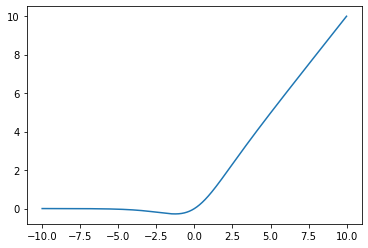

In [27]:
plt.plot(x, y_silu)

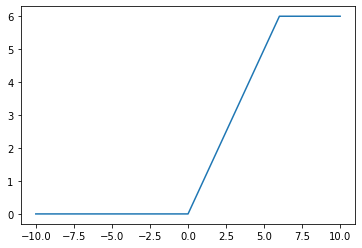

In [28]:
plt.plot(x, y_relu)

In [36]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.SEnet = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),  # B x C x H x W -> B x C x 1 x 1
            nn.Conv2d(in_channels=in_channels, out_channels=reduced_dim, kernel_size=1),  # B x C x 1 x 1 -> B x C/r x 1 x 1
            SiLU(),  # in original using ReLU
            nn.Conv2d(in_channels=reduced_dim, out_channels=in_channels, kernel_size=1),  # B x C/r x 1 x 1 -> B x C x 1 x 1
            nn.Sigmoid())

    def forward(self, x):
        return x * self.SEnet(x)

In [37]:
senet = SqueezeExcitation(in_channels=32, reduced_dim=8)

print(sum(param.numel() for param in senet.parameters() if param.requires_grad))

552


In [40]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)  # C x H x W -> C x 1 x 1
        self.linear1 = nn.Linear(in_features=in_channels, out_features=reduced_dim)  # C x 1 x 1 -> C/r x 1 x 1
        self.silu = SiLU()  # in original using ReLU
        self.linear2 = nn.Linear(in_features=reduced_dim, out_features=in_channels)  # C/r x 1 x 1 -> C x 1 x 1

    def forward(self, x):
        B, C, _, _ = x.shape

        y = self.pool(x).reshape(B, -1)  # B, C
        y = self.linear1(y)  # B, C/r
        y = self.silu(y)  # B, C/r
        y = self.linear2(y)  # B, C
        y = nn.Sigmoid()(y)  # B, C
        y = y.reshape(B, C, 1, 1)  # B, C, 1, 1

        return x * y

In [41]:
senet = SqueezeExcitation(in_channels=32, reduced_dim=8)

print(sum(param.numel() for param in senet.parameters()))

552


In [5]:
import numpy as np

In [6]:
np.array([1, 2])

array([1, 2])

In [11]:
a = np.array([np.array([1, 2])])

In [12]:
a.tolist()

[[1, 2]]

In [13]:
angles = np.arange(10)

In [16]:
angles[1::2] = angles[0::2]

In [17]:
angles

array([0, 0, 2, 2, 4, 4, 6, 6, 8, 8])